# <font color = #FF0000>**Model Preparation**</font>

## <font color = #0e46a1>**Data Acquisition**</font>

#### <font color = #696969>**Import Libraries**</font>

In [1]:
import numpy   as np
import pandas  as pd

In [2]:
import json

#### <font color = #696969>**Import Data**</font>

In [3]:
with open('Sample Data.json', 'r') as f:
    SData_json = json.load(f)
SData = pd.read_json(SData_json)

In [4]:
XData = SData.copy().drop(['is_fraud'], axis = 1)

In [5]:
YData = SData['is_fraud'].copy()

## <font color = #0e46a1>**Split into Training and Test Sets**</font>

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
XTrain, XTest, YTrain, YTest = train_test_split(XData, YData, test_size = 0.3, random_state = 2023, stratify = YData)

## <font color = #0e46a1>**Create k-Fold Cross-Validation Sets**</font>

In [8]:
from sklearn.model_selection import StratifiedKFold

In [9]:
KFold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 2023)

#### <font color = #696969>**Train the model**</font>

In [10]:
from sklearn.naive_bayes import GaussianNB

In [11]:
from sklearn.model_selection import GridSearchCV

In [12]:
def Naive():
    
    NB = GaussianNB()
    
    return NB

In [13]:
Classifier = Naive()
Classifier.class_prior_ = [0.99, 0.01]

#### <font color = #696969>**Statistical sufficiency**</font>

In [14]:
import statsmodels.api as sm

In [15]:
from sklearn.metrics         import log_loss
from sklearn.model_selection import cross_val_predict

In [16]:
def Cross_Validation(XTrain, YTrain, KFold, Classifier):
    
    TrainingScores = []
    CrossValScores = []
    
    Prediction = pd.DataFrame(data = [], index = YTrain.index, columns = [0,1])
    
    for train_index, cv_index in KFold.split(np.zeros(len(XTrain)), YTrain.ravel()):
    
        XTrain_Fold, YTrain_Fold = XTrain.iloc[train_index,:], YTrain.iloc[train_index]
        XCross_Fold, YCross_Fold = XTrain.iloc[cv_index,:],    YTrain.iloc[cv_index]
     
        Classifier.fit(XTrain_Fold, YTrain_Fold)
        
        Prediction.loc[XCross_Fold.index,:] = Classifier.predict_proba(XCross_Fold)

        loglossTraining = log_loss(YTrain_Fold, Classifier.predict_proba(XTrain_Fold)[:,1])
        loglossCV       = log_loss(YCross_Fold, Prediction.loc[XCross_Fold.index,1])
        
        TrainingScores.append(loglossTraining)
        CrossValScores.append(loglossCV)
    
        print('  Training Log Loss: ', loglossTraining)
        print('        CV Log Loss: ', loglossCV)
        
    loglossClassifier = log_loss(YTrain, Prediction.loc[:,1])
    
    print('\nClassifier Log Loss: ', loglossClassifier)
    
    return Prediction

In [17]:
Prediction = Cross_Validation(XTrain, YTrain, KFold, Classifier)

  Training Log Loss:  3.0063816611304235
        CV Log Loss:  2.8081655000116457
  Training Log Loss:  3.0187692656862417
        CV Log Loss:  3.3545828901000263
  Training Log Loss:  2.963996975114905
        CV Log Loss:  3.0386818324209783
  Training Log Loss:  2.97338616664369
        CV Log Loss:  2.9953416284303587
  Training Log Loss:  2.9622033784909294
        CV Log Loss:  2.9292072007212298
  Training Log Loss:  2.9340667599300656
        CV Log Loss:  3.044049578645029
  Training Log Loss:  2.955548707382073
        CV Log Loss:  3.2631793086340135
  Training Log Loss:  2.974999632535489
        CV Log Loss:  2.9713817041908244
  Training Log Loss:  2.9486633591915306
        CV Log Loss:  2.86250681943403
  Training Log Loss:  2.9544287468186297
        CV Log Loss:  2.903857806466593

Classifier Log Loss:  3.0171209147459668


## <font color = #0e46a1>**Model Performance**</font>

#### <font color = #696969>**Evaluate the model**</font>

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [19]:
def Scores(YTrain, Prediction):
    
    YPrediction = (Prediction >= 0.9999921202044731).astype(int)

    A = accuracy_score(YTrain, YPrediction)*100
    P = precision_score(YTrain, YPrediction)*100
    R = recall_score(YTrain, YPrediction)*100
    F = f1_score(YTrain, YPrediction)*100
    
    A_Porcent = "{:.2f}%".format(A)
    P_Porcent = "{:.2f}%".format(P)
    R_Porcent = "{:.2f}%".format(R)
    F_Porcent = "{:.2f}%".format(F)
    
    print(' Accuracy: ',A_Porcent)
    print('Precision: ',P_Porcent)
    print('   Recall: ',R_Porcent)
    print('       F1: ',F_Porcent)

In [20]:
S = Scores(YTrain, Prediction.loc[:,1])

 Accuracy:  75.48%
Precision:  83.02%
   Recall:  64.05%
       F1:  72.31%


#### <font color = #696969>**Confusion Matrix**</font>

In [21]:
import matplotlib.pyplot as plt

In [22]:
from sklearn.metrics import confusion_matrix

In [23]:
import seaborn as sns

In [24]:
YPrediction = (Prediction.loc[:,1] >= 0.9999921202044731).astype(int)

In [25]:
CM = confusion_matrix(YTrain, YPrediction)

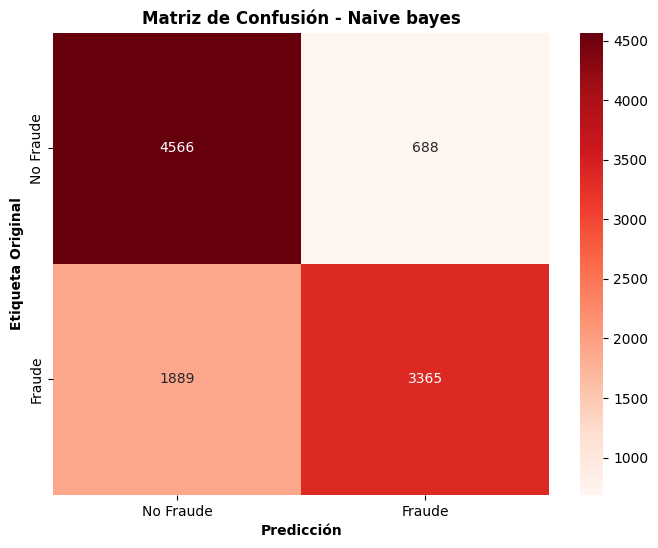

In [26]:
labels = ['No Fraude','Fraude']

plt.figure(figsize=(8, 6))
sns.heatmap(CM, annot = True, fmt="d", cmap = "Reds", xticklabels = labels, yticklabels = labels)

plt.xticks(fontweight='light')
plt.yticks(fontweight='light')

plt.xlabel('Predicción', fontweight='bold')
plt.ylabel('Etiqueta Original', fontweight='bold')

plt.title('Matriz de Confusión - Naive bayes', fontweight = 'bold')

plt.savefig('Heatmap - NB - Entrenamiento.png')

plt.show()

#### <font color = #696969>**Precision-Recall Curve**</font>

In [27]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score

In [28]:
def Curves(YTrain, AnomalyScores, returnPredictions = False):

    Predictions = pd.concat([YTrain, AnomalyScores], axis = 1)
    Predictions.columns = ['True', 'Prediction: AnomalyScores']

    Precision, Recall, Thresholds = precision_recall_curve(Predictions['True'], Predictions['Prediction: AnomalyScores'])

    Average_Precision = average_precision_score(Predictions['True'],Predictions['Prediction: AnomalyScores'])

    plt.step(Recall, Precision, color = 'red', alpha = 0.7, where = 'post')

    plt.fill_between(Recall, Precision, step = 'post', alpha = 0.3, color = 'red')

    plt.xlabel('Sensibilidad ')
    plt.ylabel('Precisión ')

    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])

    plt.title('Curva de Precisión-Sensibilidad: Precisión Promedio = {0:0.2f}'.format(Average_Precision), fontweight = 'bold')
    
    plt.savefig('ROC - NB - Entrenamiento.png')

    plt.show()

    fpr, tpr, thresholds = roc_curve(Predictions['True'], Predictions['Prediction: AnomalyScores'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color = 'red', lw = 2, label = 'Curva ROC')
    plt.plot([0, 1], [0, 1], color = 'k', lw = 2, linestyle = '--')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.xlabel('Proporción Falsos Positivos')
    plt.ylabel('Proporción Verdaderos Positivos')

    #plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(areaUnderROC), fontweight = 'bold')
    plt.title('Área bajo la Curva = {0:0.2f}'.format(areaUnderROC), fontweight = 'bold')
    plt.legend(loc = "lower right")
    
    plt.savefig('AUC - NB - Entrenamiento.png')
    
    plt.show()

    if returnPredictions == True:
        return Predictions

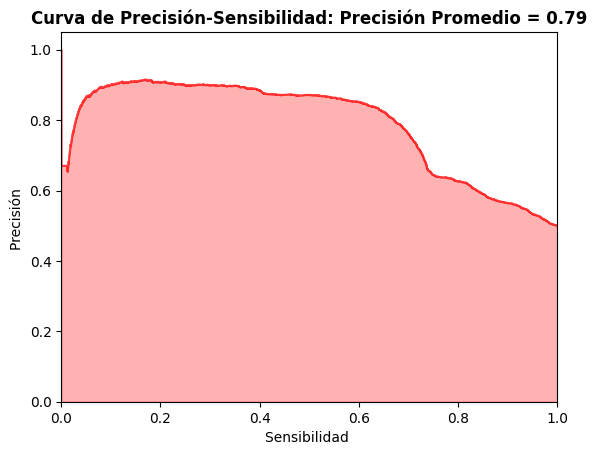

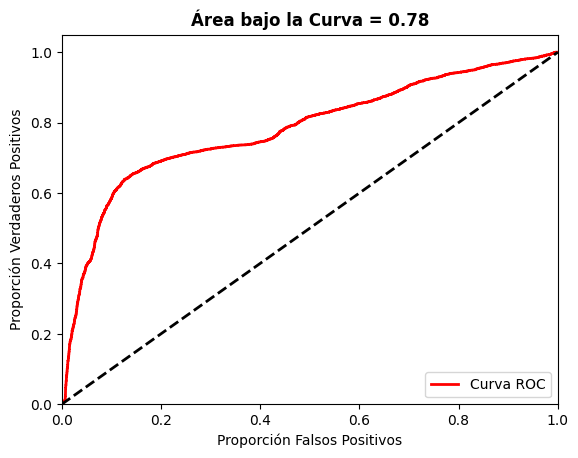

In [29]:
Curves = Curves(YTrain, Prediction.loc[:,1],True)

#### <font color = #696969>**Test the model**</font>

In [30]:
def Performance(XTest, YTest, Classifier):
    
    Predictions = pd.DataFrame(data = [],index = YTest.index, columns = ['prediction'])
    
    Predictions[Predictions.columns[0]] = Classifier.predict_proba(XTest)[:, 1]
    
    loglossClassifier = log_loss(YTest, Predictions)
    
    print('Classifier Log Loss: ', loglossClassifier)
    
    return Predictions

In [31]:
Predictions = Performance(XTest, YTest, Classifier)

Classifier Log Loss:  2.9994799700456234


In [32]:
def Score(YTrain, Prediction):
    
    YPrediction = (Prediction >= 0.9999921202044731).astype(int)

    A = accuracy_score(YTrain, YPrediction)*100
    P = precision_score(YTrain, YPrediction)*100
    R = recall_score(YTrain, YPrediction)*100
    F = f1_score(YTrain, YPrediction)*100
    
    A_Porcent = "{:.2f}%".format(A)
    P_Porcent = "{:.2f}%".format(P)
    R_Porcent = "{:.2f}%".format(R)
    F_Porcent = "{:.2f}%".format(F)
    
    print(' Accuracy: ',A_Porcent)
    print('Precision: ',P_Porcent)
    print('   Recall: ',R_Porcent)
    print('       F1: ',F_Porcent)

In [33]:
Scores = Score(YTest, Predictions)

 Accuracy:  75.67%
Precision:  82.62%
   Recall:  65.01%
       F1:  72.76%


In [34]:
YPrediction = (Predictions >= 0.9999921202044731).astype(int)

In [35]:
CM = confusion_matrix(YTest, YPrediction)

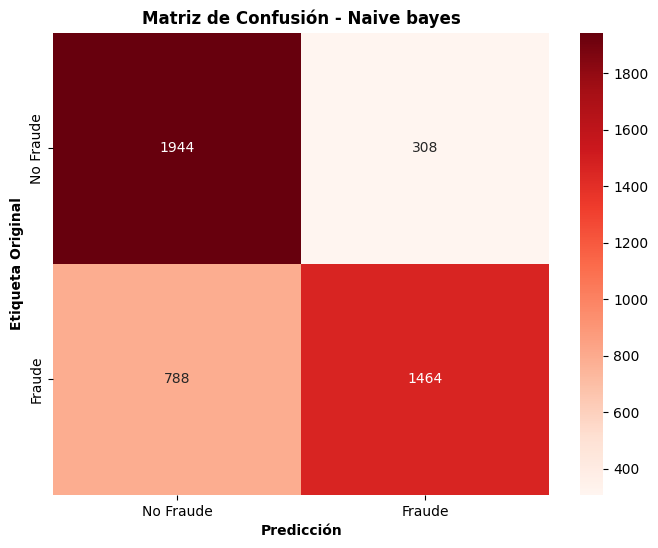

In [36]:
labels = ['No Fraude','Fraude']

plt.figure(figsize = (8, 6))
sns.heatmap(CM, annot = True, fmt="d", cmap = "Reds", xticklabels = labels, yticklabels = labels)

plt.xticks(fontweight ='light')
plt.yticks(fontweight ='light')

plt.xlabel('Predicción', fontweight = 'bold')
plt.ylabel('Etiqueta Original', fontweight = 'bold')

plt.title('Matriz de Confusión - Naive bayes', fontweight = 'bold')

plt.savefig('Heatmap - NB - Prueba.png')

plt.show()

In [37]:
def Curve(YTrain, AnomalyScores, returnPredictions = False):

    Predictions = pd.concat([YTrain, AnomalyScores], axis = 1)
    Predictions.columns = ['True', 'Prediction: AnomalyScores']

    Precision, Recall, Thresholds = precision_recall_curve(Predictions['True'], Predictions['Prediction: AnomalyScores'])

    Average_Precision = average_precision_score(Predictions['True'],Predictions['Prediction: AnomalyScores'])

    plt.step(Recall, Precision, color = 'red', alpha = 0.7, where = 'post')

    plt.fill_between(Recall, Precision, step = 'post', alpha = 0.3, color = 'red')

    plt.xlabel('Sensibilidad ')
    plt.ylabel('Precisión ')

    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])

    plt.title('Curva de Precisión-Sensibilidad: Precisión Promedio = {0:0.2f}'.format(Average_Precision), fontweight = 'bold')
    
    plt.savefig('ROC - NB - Prueba.png')

    plt.show()

    fpr, tpr, thresholds = roc_curve(Predictions['True'], Predictions['Prediction: AnomalyScores'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color = 'red', lw = 2, label = 'Curva ROC')
    plt.plot([0, 1], [0, 1], color = 'k', lw = 2, linestyle = '--')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.xlabel('Proporción Falsos Positivos')
    plt.ylabel('Proporción Verdaderos Positivos')

    #plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(areaUnderROC), fontweight = 'bold')
    plt.title('Área bajo la Curva = {0:0.2f}'.format(areaUnderROC), fontweight = 'bold')
    plt.legend(loc = "lower right")
    
    plt.savefig('AUC - NB - Prueba.png')
    
    plt.show()

    if returnPredictions == True:
        return Predictions

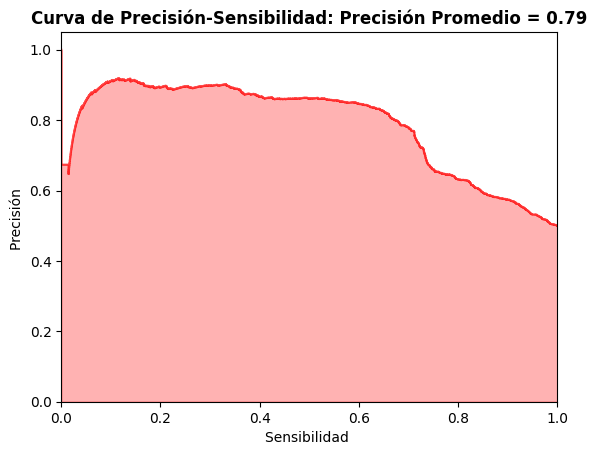

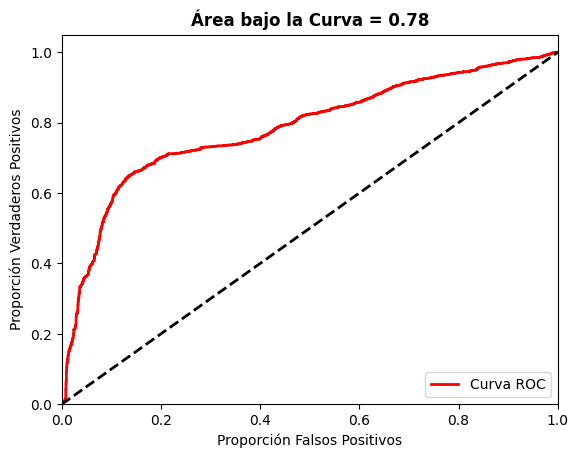

In [38]:
Curves = Curve(YTest, Predictions, True)

In [39]:
precisions, recalls, thresholds = roc_curve(YTest, Predictions)

optimal_idx = np.argmax(recalls - precisions)
optimal_threshold = thresholds[optimal_idx]

print("Umbral óptimo:", optimal_threshold)

Umbral óptimo: 0.9999921202044731


#### <font color = #696969>**Prediction Probabilities**</font>